In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
from scipy.stats import skew
%matplotlib inline
import quantstats as qs
qs.extend_pandas()
import empyrical

import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

class patternAIdetect :

    
    def __init__(self):
            import numpy as np
            import empyrical

    def backtest(self,THRESHOLD_VALUE , THRESHOLD_PATTERN , data , price, pattern_detect , bigpointvalue , type):

        np_data = data.T.values
        np_price = price.T.values
        ptn_body =  pattern_detect[0]
        ptn_range = pattern_detect[1]
        direzione = pattern_detect[2][0]
        lookback = pattern_detect[2][2]
        n_days = pattern_detect[2][1]
        
        pct=round(1-float((1/100)*THRESHOLD_VALUE),2)
        pct_total=int((lookback/100)*THRESHOLD_PATTERN)

        backtest = engine(pct , pct_total , ptn_body , ptn_range , np_data, np_price, direzione , lookback , n_days)

        if len(backtest[0])>1:
            
            if type == "full" :
    
                pnl = np.multiply( backtest[0] , bigpointvalue )
                date_open_position = data.index[list(np.asarray(list(backtest[1]), dtype="object")[:,0])]
                date_close_position = data.index[list(np.asarray(list(backtest[1]), dtype="object")[:,1])]
                
                tradelist = pd.DataFrame([date_close_position,date_open_position,pnl]).T
                tradelist.columns = (["exit_time" , "entry_time" , "operations"])
                tradelist.set_index(["exit_time"],inplace=True)
                tradelist.index=pd.to_datetime(tradelist.index)
                tradelist["direction"] = direzione
                    
                return tradelist
                
            elif type == "basic" :
    
                return np.multiply(backtest[0] , bigpointvalue )
            
        else:
            return pd.DataFrame(columns=["exit_time" , "entry_time" , "operations"])

    def optimize(self,THRESHOLD_VALUE , THRESHOLD_PATTERN , data , price, pattern_detect , bigpointvalue , type , n_days):

        np_data = data.T.values
        np_price = price.T.values
        ptn_body =  pattern_detect[0]
        ptn_range = pattern_detect[1]
        direzione = pattern_detect[2][0]
        lookback = pattern_detect[2][2]
        
        pct=round(1-float((1/100)*THRESHOLD_VALUE),2)
        pct_total=int((lookback/100)*THRESHOLD_PATTERN)

        backtest = engine(pct , pct_total , ptn_body , ptn_range , np_data, np_price, direzione , lookback , n_days)

        if len(backtest[0])>1:
            
            if type == "full" :
    
                pnl = np.multiply( backtest[0] , bigpointvalue )
                date_open_position = data.index[list(np.asarray(list(backtest[1]), dtype="object")[:,0])]
                date_close_position = data.index[list(np.asarray(list(backtest[1]), dtype="object")[:,1])]
                
                tradelist = pd.DataFrame([date_close_position,date_open_position,pnl]).T
                tradelist.columns = (["exit_time" , "entry_time" , "operations"])
                tradelist.set_index(["exit_time"],inplace=True)
                tradelist.index=pd.to_datetime(tradelist.index)
                tradelist["direction"] = direzione
                    
                return tradelist
                
            elif type == "basic" :
    
                return np.multiply(backtest[0] , bigpointvalue )
            
        else:
            return pd.DataFrame(columns=["exit_time" , "entry_time" , "operations"])
        

    def detect(self,data,price,n_days,lookback,fraction_movement):

        np_data = data.T.values
        np_price = price.T.values
        np_open = np_price[0]
        
        pattern_ls=[]
        
        for i in (range(len(np_data[0]))):
            op=np_data[0][i-lookback:i]
            hi=np_data[1][i-lookback:i]
            lo=np_data[2][i-lookback:i]
            cl=np_data[3][i-lookback:i]

            try :
                for n in range(n_days,n_days+1): 
                    if  np_open[i+1] - np_open[i+n+1] >= fraction_movement*np_open[i+1]:
                        if i >=lookback :
                            a=cl-op
                            body=(a - np.min(a))/np.ptp(a)
                            a=hi-lo
                            range_=(a - np.min(a))/np.ptp(a)
                            info = ["buy",int(n),int(lookback),float(fraction_movement),int(i)]
                            pattern_ls.append([body,range_,info])
                        #print('Down',i,n)
                        break
                    elif np_open[i+n+1] - np_open[i+1] >= fraction_movement*np_open[i+1] :
                        if i >lookback :                    
                            a=cl-op
                            body=(a - np.min(a))/np.ptp(a)
                            a=hi-lo
                            range_=(a - np.min(a))/np.ptp(a)
                            info = ["sell",int(n),int(lookback),float(fraction_movement),int(i)]
                            pattern_ls.append([body,range_,info])
                        #print('Up',i,n)
                        break
            except :
                pass

        pattern_detect = np.asarray(pattern_ls, dtype="object")
        
        ls_tmp = []
        for e in pattern_detect[:,2]:
            ls_tmp.append(e[0])
        
        print("Found", len(ls_tmp) ,"patterns")
        print("Buy" ,len([e for e in ls_tmp if "buy" == e]))
        print("Sell" , len(ls_tmp)-(len([e for e in ls_tmp if "buy" == e])))
                
        return pattern_detect

    def performance_report_gen(self,tradelist):
        res=pd.DataFrame()
        d = {"Profit": sum(tradelist),
             "Operations":len(tradelist),
             "Percent_Win": self.percent_win(tradelist),
             "Avg_Trade" : np.mean(tradelist),
             "Performance_Ratio": self.Performance_Ratio(tradelist),
            }
        res=pd.DataFrame(data=d,index=[0])
        return res
    
    def Performance_Ratio(self,operations):
    
        pct = self.percent_win(operations)/100
        return ( operations[operations>0].mean() / abs(operations[operations<0].mean()) ) * pct
   

    def old_sharpe_ratio(self,operations):
        """
        Il rapporto tra il guadagno totale 
        e la deviazione standard dell'equity line
        """
        equity = operations.cumsum()
        netprofit = equity[-1]
        std = equity.std()
        if std != 0:
            return round(netprofit / std,2)
        else:
            return np.inf

    def percent_win(self,operations):
        return round((operations[operations > 0].count() / operations.count() * 100),2)

    def information_ratio(self,operations):
        tmp = operations.resample("B").sum()
        return  (252**0.5) * (tmp.mean() / tmp.std())
    
    def stats(self , backtest , IDX , direz):

        if len(backtest)>0:

            try:
                operations = pd.Series(backtest)
            except:
                   operations = backtest.operations
     
            stat = self.performance_report_gen(operations)
            stat["information_ratio"] = self.information_ratio(operations)    
            stat["sharpe_ratio"] =  empyrical.sharpe_ratio(operations)
            stat["STD"] = operations.std()
            stat["worst_loss"] = operations.min()
            stat["worst_loss_10_days"] = operations.rolling(10 , min_periods=10).sum().min()
            stat["pattern_number"] = IDX
            stat["action"] = direz
            
            return stat
        else:
            return pd.DataFrame()

    def check_direction(self,IDX,pattern_detect):
        return pattern_detect[IDX][2][0]

    def plot_pattern(self,pattern_detect,IDX,dataset):

        import mplfinance as mpf
        
        position = pattern_detect[IDX][2][4]
        lookback = pattern_detect[IDX][2][2]
        direction = pattern_detect[IDX][2][0]
        
        df=dataset.iloc[position-lookback:position] 
        found = str(df.index[-1].date())
        
        mpf.plot(df, type='candle', style='yahoo', volume=False, title='Pattern_N:'+str(IDX)+" "+direction+" Found:"+found , axisoff=True)

    def ottimizza_TP_SL(self, v1, v2, data_M5, backtest , direction, BIGPOINTVALUE ):
    
        print("Ricalcolo Open Balance...")
    
        price_M5 = (data_M5.open.shift(-1)-data_M5.open)*BIGPOINTVALUE 
        
        np_index = []
        np_operations = []
        for e in range(len(backtest)):
            x = price_M5.loc[str(backtest.entry_time.iloc[e]):str(backtest.index[e])]
            if direction == "sell":
                x = -x
            np_operations.append(x.cumsum().values)
            np_index.append(str(backtest.entry_time.iloc[e]))
    
        print("Ottimizzazione...")
        
        results = []  # Lista per raccogliere i risultati intermedi come array NumPy
        for mfe in tqdm(v1):
            for mae in v2:
                new_pnl = []
                for k, operation in enumerate(np_operations):
                    pnl = 0
                    yes_mae = 0
                    yes_mfe = 0
                    
                    if len(operation) > 0:
                        min_i_idx = np.argmin(operation)
                        max_i_idx = np.argmax(operation)
                        min_i = operation[min_i_idx]
                        max_i = operation[max_i_idx]
                        
                        if min_i <= mae and max_i < mfe:
                            pnl = mae
                            yes_mae = 1    
    
                        if max_i >= mfe and min_i > mae:
                            pnl = mfe
                            yes_mfe = 1
    
                        if min_i <= mae and max_i >= mfe:
                            if min_i_idx < max_i_idx:
                                pnl = mae
                                yes_mae = 1 
                            elif max_i_idx < min_i_idx:
                                pnl = mfe
                                yes_mfe = 1      
    
                        if yes_mae == 0 and yes_mfe == 0:
                            pnl = operation[-1]
                            
                        new_pnl.append([np_index[k], pnl])
                    
                results.append(new_pnl)  # Aggiungi il risultato come array NumPy
            
        ott = np.array(results)  # Converti la lista dei risultati in un array NumPy
       
        print("Ricostruisco Dataframe...")
        
        df = pd.DataFrame()
        for i, data in enumerate(ott):
            s = pd.Series(index=data[:, 0], data=data[:, 1])
            column_name = f'ott_{i + 1}'
            df[column_name] = s
    
        ott_dataframe = df.copy()
            
        # Rinomina le colonne in base a v1 e v2
        v1_v2_columns = [f'{mfe}_{mae}' for mfe in v1 for mae in v2]
        ott_dataframe.columns = v1_v2_columns
        ott_dataframe = ott_dataframe.apply(pd.to_numeric, errors='coerce')
        ott_dataframe.index = pd.to_datetime(ott_dataframe.index)
    
        print("Calcolo delle Performace...")
        
        ls=[]
        ls2=[]
        ls3=[]
        ls4=[]
        import empyrical
        for e in tqdm(ott_dataframe.columns):
            x=ott_dataframe[e]
            ls.append(empyrical.sharpe_ratio(x))
            ls2.append(np.mean(x))
            ls3.append(empyrical.sortino_ratio(x))
            ls4.append(empyrical.max_drawdown(x))
        
        backtest.operations.cumsum().plot(label="Originale",figsize=(9,8))
        (ott_dataframe).iloc[:,ls.index(max(ls))].cumsum().plot(label="Sharpe_Ratio")
        (ott_dataframe).iloc[:,ls2.index(max(ls2))].cumsum().plot(label="Avg_Trade")
        (ott_dataframe).iloc[:,ls3.index(max(ls3))].cumsum().plot(label="Sortino_Ratio")
        (ott_dataframe).iloc[:,ls4.index(max(ls4))].cumsum().plot(label="Max_Drawdown")
        plt.legend()
        plt.show()
        
        print(" Sharpe_Ratio",ott_dataframe.iloc[:,ls.index(max(ls))].name,"\n",
        "Avg_Trade",ott_dataframe.iloc[:,ls2.index(max(ls2))].name,"\n",
        "Sortino_Ratio",ott_dataframe.iloc[:,ls3.index(max(ls3))].name,"\n",
        "Max_Drawdown",ott_dataframe.iloc[:,ls4.index(max(ls4))].name)
        
patternAI = patternAIdetect()

In [95]:
@jit(nopython=True)
def my_sum(d):
    total = 0.0
    for valore in d:
        total += valore
    return total


@jit(nopython=True)
def engine(pct , pct_total , ptn_body , ptn_range , np_data, np_price, direzione ,lookback , n_days):

    gain_loss=[]
    ls_date=[]
    conta=0
    mp=np.zeros_like(np_data[0])
    np_open = np_price[0]
    
    for i in (range(len(np_open)-n_days-1)):
        if i >lookback:
            op=np_data[0,i-lookback:i] 
            hi=np_data[1,i-lookback:i]
            lo=np_data[2,i-lookback:i]
            cl=np_data[3,i-lookback:i]
    
            a=cl-op
            body=(a - np.min(a))/np.ptp(a)  
            
            a=hi-lo
            range_=(a - np.min(a))/np.ptp(a)
     
            diff_1=body-ptn_body
            diff_2=range_-ptn_range
            diff_1=np.where((diff_1<pct)&(diff_1>-pct),1,diff_1)
            diff_1=np.where(diff_1!=1,0,diff_1)
            diff_2=np.where((diff_2<pct)&(diff_2>-pct),1,diff_2)
            diff_2=np.where(diff_2!=1,0,diff_2)

            
            if (my_sum(diff_1)>=pct_total)&(my_sum(diff_2)>=pct_total)&(direzione=="buy")&(mp[i]==0):
                mp[i+1:i+n_days+1]=1
                gl_1=np_open[i+n_days+1] - np_open[i+1]
                gain_loss.append(gl_1)
                ls_date.append([i+1,i+n_days+1])
                
            if (my_sum(diff_1)>=pct_total)&(my_sum(diff_2)>=pct_total)&(direzione=="sell")&(mp[i]==0):
                mp[i+1:i+n_days+1]=1
                gl_1=np_open[i+1] - np_open[i+n_days+1] 
                gain_loss.append(gl_1)
                ls_date.append([i+1,i+n_days+1])
                
    return gain_loss , ls_date     

def report(tradelist,initial_capital,type_analisy,Benchmark):
        %matplotlib inline
        import quantstats as qs
        qs.extend_pandas()
    
        tradelist = tradelist.fillna(0)
        tradelist = tradelist[tradelist!=0]
        tradelist.iloc[0] = tradelist.iloc[0]+initial_capital
        tradelist = tradelist.cumsum()
        
        if type_analisy == 0:
            qs.plots.snapshot(tradelist)
            
        if type_analisy == 1:    
            if len(Benchmark)==0:
                qs.reports.basic(tradelist)
            else:
                qs.reports.basic(tradelist,Benchmark)
                
        if type_analisy == 2:    
            if len(Benchmark)==0:
                qs.reports.full(tradelist)
            else:
                qs.reports.full(tradelist,Benchmark)

In [96]:
%matplotlib inline
import quantstats as qs
qs.extend_pandas()

path=(r"C:\Program Files\AMP Global (USA) MT5 Exchange-Traded Futures Only 2\terminal64.exe")

ls_mercati=["AUDCAD","AUDCHF","AUDJPY","AUDNZD","AUDUSD","CADCHF","CADJPY","CHFJPY","EURAUD","EURCAD","EURCHF","EURGBP","EURJPY",\
            "EURNZD","EURUSD","GBPAUD","GBPCAD","GBPCHF","GBPJPY","GBPNZD","GBPUSD","NZDCAD","NZDCHF","NZDJPY","NZDUSD","USDCAD",\
            "USDCHF","USDJPY"]

def readdata(market,tf,barre,path):
    from datetime import datetime
    import MetaTrader5 as mt5
    import pandas as pd

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    
    mk=str(market)
    TF="mt5.TIMEFRAME_"+str(tf)
    bar=barre
     
    while True:

        try:
            rates = mt5.copy_rates_from_pos(mk, eval(TF), 0, bar) #1700
            if len(rates)>0:
                break
        except:
            continue

    rates_frame = pd.DataFrame(rates)
    rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
    rates_frame=rates_frame[["time","open","high","low","close","tick_volume"]]
    rates_frame.columns=(["time","open","high","low","close","volume"])
    rates_frame=rates_frame.set_index(["time"])
    rates_frame=rates_frame[(rates_frame.T != 0).any()]
    return rates_frame


def readdata_MT5_Date(market,tf,path,start,stop):
    
    from datetime import datetime
    import MetaTrader5 as mt5
    import pandas as pd
    
    while True:

        if not mt5.initialize(path):
            print("initialize() failed, error code =",mt5.last_error())
            quit()
        mk=str(market)
        TF="mt5.TIMEFRAME_"+str(tf)

        start_y , start_m , start_d = start.split("-")
        stop_y , stop_m , stop_d = stop.split("-")
        
        utc_from = datetime(int(start_y), int(start_m), int(start_d))
        utc_to = datetime(int(stop_y), int(stop_m), int(stop_d))
        
        rates = mt5.copy_rates_range(mk, eval(TF), utc_from, utc_to) 
    

        rates_frame = pd.DataFrame(rates)
        rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
        rates_frame=rates_frame[["time","open","high","low","close","tick_volume"]]
        rates_frame.columns=(["time","open","high","low","close","volume"])
        rates_frame=rates_frame.set_index(["time"])
        #rates_frame=rates_frame[(rates_frame.T != 0).any()]
        if rates_frame is not None:
            return rates_frame
            break

def get_poin_values(path,simb):

    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    symbol_info=mt5.symbol_info(simb)
    if symbol_info!=None:
        symbol_info_dict = mt5.symbol_info(simb)._asdict()
    mt5.shutdown()    
    tmp=symbol_info_dict['trade_tick_value']/symbol_info_dict['point']
    return tmp



In [97]:

simbolo = "NZDJPY"

BIGPOINTVALUE=get_poin_values(path,simbolo)

price = readdata_MT5_Date(simbolo,"H1",path,"2010-01-01","2023-08-28")

price.head() ,price.tail()


(                       open    high     low   close  volume
 time                                                       
 2010-01-04 00:00:00  67.076  67.141  66.982  66.989    2708
 2010-01-04 01:00:00  66.990  67.027  66.889  66.906    2473
 2010-01-04 02:00:00  66.907  67.020  66.845  66.897    1823
 2010-01-04 03:00:00  66.896  66.904  66.742  66.800    1661
 2010-01-04 04:00:00  66.802  66.890  66.796  66.842    1097,
                        open    high     low   close  volume
 time                                                       
 2023-08-25 19:00:00  86.346  86.452  86.341  86.425    2360
 2023-08-25 20:00:00  86.427  86.470  86.360  86.470    2480
 2023-08-25 21:00:00  86.470  86.595  86.457  86.588    2281
 2023-08-25 22:00:00  86.591  86.604  86.500  86.519    1647
 2023-08-25 23:00:00  86.518  86.522  86.415  86.439    1046)

In [98]:

simbolo = "NZDJPY"

dataset = readdata_MT5_Date(simbolo,"H1",path,"2010-01-01","2023-08-28")

dataset.head() ,dataset.tail()

(                       open    high     low   close  volume
 time                                                       
 2010-01-04 00:00:00  67.076  67.141  66.982  66.989    2708
 2010-01-04 01:00:00  66.990  67.027  66.889  66.906    2473
 2010-01-04 02:00:00  66.907  67.020  66.845  66.897    1823
 2010-01-04 03:00:00  66.896  66.904  66.742  66.800    1661
 2010-01-04 04:00:00  66.802  66.890  66.796  66.842    1097,
                        open    high     low   close  volume
 time                                                       
 2023-08-25 19:00:00  86.346  86.452  86.341  86.425    2360
 2023-08-25 20:00:00  86.427  86.470  86.360  86.470    2480
 2023-08-25 21:00:00  86.470  86.595  86.457  86.588    2281
 2023-08-25 22:00:00  86.591  86.604  86.500  86.519    1647
 2023-08-25 23:00:00  86.518  86.522  86.415  86.439    1046)

In [6]:
price = price[price.index.isin(dataset.index)]
dataset = dataset[dataset.index.isin(price.index)]
len(dataset) , len(price)

(10527, 10527)

In [130]:
LOOK_AHEAD = 8
LOOK_BACK = 60
FRACTION_MOVEMENT = 0.01

pattern_detect  = patternAI.detect(dataset ,price , LOOK_AHEAD , LOOK_BACK , FRACTION_MOVEMENT)


Found 3375 patterns
Buy 1861
Sell 1514


In [9]:
import ray

ray.init()

2023-09-05 18:36:15,716	INFO worker.py:1621 -- Started a local Ray instance.


Python version:,3.8.17
Ray version:,2.6.3


In [131]:
THRESHOLD_VALUE = 70
THRESHOLD_PATTERN = 70

ray.RAY_DEDUP_LOGS=0
@ray.remote
def run_backtest_and_stats(patternAI, threshold_value, threshold_pattern, dataset, price, pattern_idx, big_point_value,idx):
    backtest = patternAI.backtest(threshold_value, threshold_pattern, dataset, price,pattern_idx, big_point_value, "full")
    stats = patternAI.stats(backtest, idx, patternAI.check_direction(idx, pattern_detect))
    return stats 

results_futures = []
for idx in tqdm(range(len(pattern_detect))):
    future = run_backtest_and_stats.remote(patternAI, THRESHOLD_VALUE , THRESHOLD_PATTERN, dataset, price,pattern_detect[idx], BIGPOINTVALUE ,idx)
    results_futures.append(future)
    
results = pd.DataFrame()
for future in tqdm(ray.get(results_futures)):
    results = pd.concat([results, future])


  0%|          | 0/3375 [00:00<?, ?it/s]

  0%|          | 0/3375 [00:00<?, ?it/s]

In [133]:
results = results.sort_values("Profit",ascending=False)
filtered_results =  results[(results.Performance_Ratio	>0.5) & (results.Operations>300)]      ######(abs(results.worst_loss_10_days)<results.STD*5) (abs(results.worst_loss)<results.STD*3) 
filtered_results

,Profit,Operations,Percent_Win,Avg_Trade,Performance_Ratio,information_ratio,sharpe_ratio,STD,worst_loss,worst_loss_10_days,pattern_number,action
0,47181.791787,7635,52.10,6.179671,0.518167,0.664105,0.453348,216.388214,-2065.213275,-4983.778734,148,buy
0,38503.099082,4153,53.21,9.271153,0.527643,0.760393,0.702186,209.595464,-1281.290632,-3060.580431,792,buy
0,37725.488216,7805,51.56,4.833503,0.513846,0.524089,0.353975,216.765456,-2501.988210,-2998.093843,2505,buy
0,37510.887814,7307,52.09,5.133555,0.511076,0.546488,0.376258,216.586950,-1863.236427,-3439.918199,3079,buy
0,37485.640708,7727,52.30,4.851254,0.505855,0.528388,0.353200,218.038872,-3865.963114,-3503.667142,2788,buy
...,...,...,...,...,...,...,...,...,...,...,...,...
0,-20286.049712,6808,47.78,-2.979737,0.500617,-0.301830,-0.215532,219.465780,-1747.730916,-2390.269765,2191,sell
0,-20424.277617,7933,48.13,-2.574597,0.500329,-0.278424,-0.186698,218.911680,-1850.612873,-3395.104586,2243,sell
0,-21429.112438,6930,47.46,-3.092224,0.503528,-0.310332,-0.222449,220.668982,-1382.279056,-2614.969009,142,sell
0,-22468.030852,7059,47.66,-3.182891,0.500112,-0.329955,-0.229496,220.164494,-1766.035068,-3187.447139,1819,sell


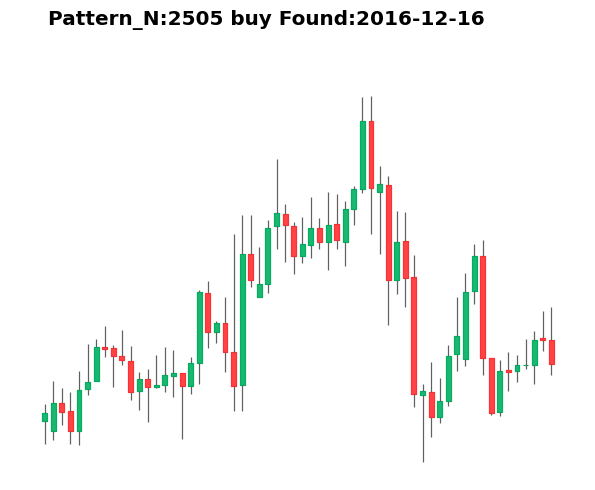

                    Strategy
------------------  ----------
Start Period        2010-01-06
End Period          2023-08-25
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   37.28%
CAGR﹪              1.62%

Sharpe              0.36
Prob. Sharpe Ratio  97.62%
Sortino             0.5
Sortino/√2          0.36
Omega               1.07

Max Drawdown        -6.36%
Longest DD Days     1369

Gain/Pain Ratio     0.1
Gain/Pain (1M)      0.53

Payoff Ratio        1.0
Profit Factor       1.07
Common Sense Ratio  1.09
CPC Index           0.55
Tail Ratio          1.02
Outlier Win Ratio   3.82
Outlier Loss Ratio  3.82

MTD                 -0.78%
3M                  1.89%
6M                  1.81%
YTD                 1.79%
1Y                  2.89%
3Y (ann.)           2.68%
5Y (ann.)           1.93%
10Y (ann.)          1.39%
All-time (ann.)     1.62%

Avg. Drawdown       -0.79%
Avg. Drawdown Days  38
Recovery Factor     5.2
Ulcer Index         0.02
Serenity Index      0.69


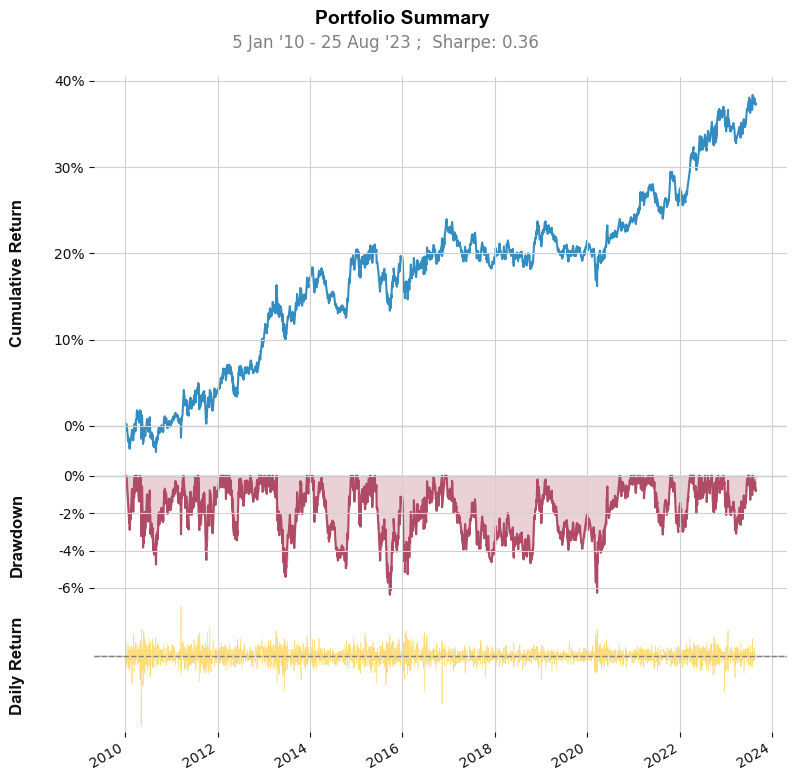

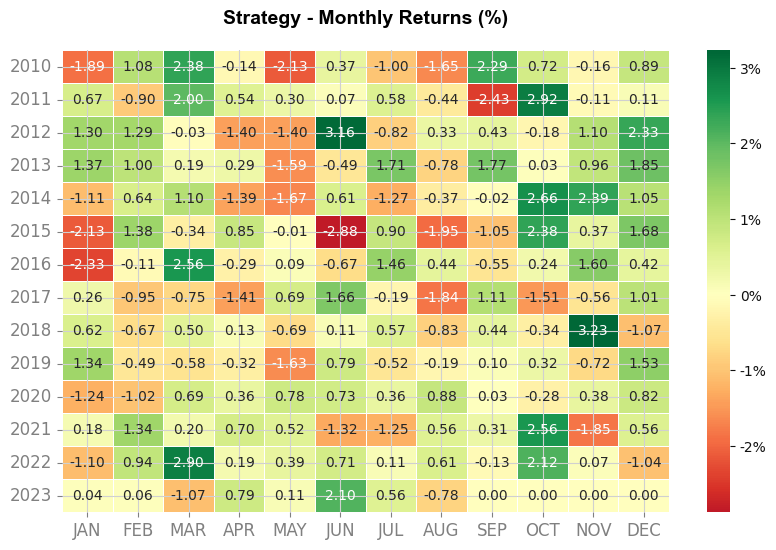

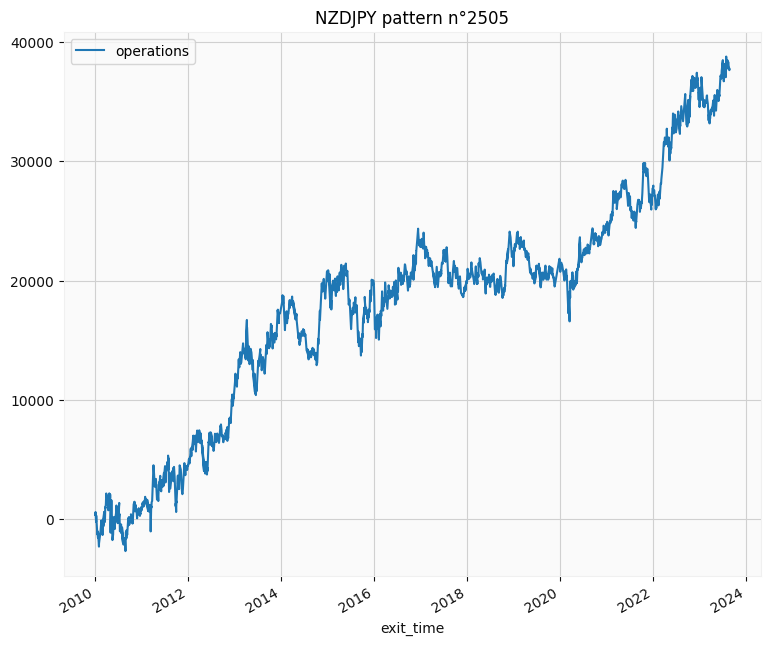

In [137]:
IDX = 2505

backtest = patternAI.backtest(THRESHOLD_VALUE , THRESHOLD_PATTERN, dataset , price, pattern_detect[IDX] , BIGPOINTVALUE , "full")

patternAI.plot_pattern(pattern_detect,IDX,dataset)

report(backtest.operations,100000,1,"")

backtest.operations.cumsum().plot(figsize=(9,8),title=simbolo+" pattern n°"+str(IDX))
plt.legend()
plt.show()

In [102]:
import optuna
import ray
from ray import tune
from ray.tune.search.optuna import OptunaSearch

idx = IDX

ray.RAY_DEDUP_LOGS=0

def run_optimize_and_stats(config):
    threshold_value = config["threshold_value"]
    threshold_pattern = config["threshold_pattern"]
    look_ahead = config["look_ahead"]
    
    backtest = patternAI.optimize(threshold_value, threshold_pattern, dataset , price, pattern_detect[idx], BIGPOINTVALUE, "full", look_ahead)
    stats = patternAI.stats(backtest, idx, patternAI.check_direction(idx, pattern_detect))
    if len(stats)>0:
        if (stats.Operations.iloc[0] >1000) :  ####### n_op min
            return stats['sharpe_ratio'].iloc[0] 
        else:
            return -99999999
    else:
        return -99999999

search_alg = OptunaSearch(mode="max")
analysis = tune.run(
    run_optimize_and_stats,
    config={
        "threshold_value": tune.randint(65, 75),  ####### threshold_value range
        "threshold_pattern": tune.randint(65, 75), ####### threshold_pattern range
        "look_ahead": tune.randint(4, 10), ###### look_ahead range
    },
    search_alg=search_alg,
    num_samples=100,
    mode="max" ,verbose=1
)

best_params = analysis.best_config
print("Migliori parametri:", best_params)

2023-09-05 18:20:33,268	WARNING tune.py:1122 -- Trial Runner checkpointing failed: Sync process failed: [WinError 32] Failed copying 'C:/Users/Drako/ray_results/run_optimize_and_stats_2023-09-05_18-20-04/experiment_state-2023-09-05_18-20-04.json' to 'c:/Users/Drako/ray_results/run_optimize_and_stats_2023-09-05_18-20-04/experiment_state-2023-09-05_18-20-04.json'. Detail: [Windows error 32] Impossibile accedere al file. Il file � utilizzato da un altro processo.

2023-09-05 18:20:36,527	INFO tune.py:1148 -- Total run time: 32.23 seconds (28.80 seconds for the tuning loop).


Migliori parametri: {'threshold_value': 70, 'threshold_pattern': 65, 'look_ahead': 9}


In [113]:
####### se non si ottimizza

idx = IDX
best_params = {'threshold_value': THRESHOLD_VALUE, 'threshold_pattern': THRESHOLD_PATTERN, 'look_ahead': LOOK_AHEAD}

,Profit,Operations,Percent_Win,Avg_Trade,Performance_Ratio,information_ratio,sharpe_ratio,STD,worst_loss,worst_loss_10_days,pattern_number,action
0,20197.053663,1620,51.67,12.467317,0.595939,0.74183,1.070398,184.896281,-753.626116,-1723.114988,820,sell


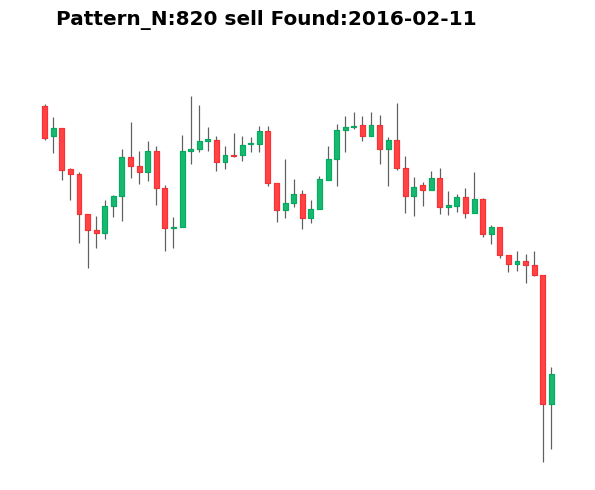

                    Strategy
------------------  ----------
Start Period        2010-01-13
End Period          2023-08-01
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   20.23%
CAGR﹪              0.94%

Sharpe              1.08
Prob. Sharpe Ratio  99.88%
Sortino             1.86
Sortino/√2          1.32
Omega               1.24

Max Drawdown        -3.48%
Longest DD Days     897

Gain/Pain Ratio     0.38
Gain/Pain (1M)      1.0

Payoff Ratio        1.16
Profit Factor       1.24
Common Sense Ratio  1.5
CPC Index           0.74
Tail Ratio          1.21
Outlier Win Ratio   4.01
Outlier Loss Ratio  4.2

MTD                 0.14%
3M                  -0.2%
6M                  0.17%
YTD                 0.44%
1Y                  -0.1%
3Y (ann.)           0.59%
5Y (ann.)           0.46%
10Y (ann.)          0.85%
All-time (ann.)     0.94%

Avg. Drawdown       -0.44%
Avg. Drawdown Days  65
Recovery Factor     5.37
Ulcer Index         0.01
Serenity Index      2.07


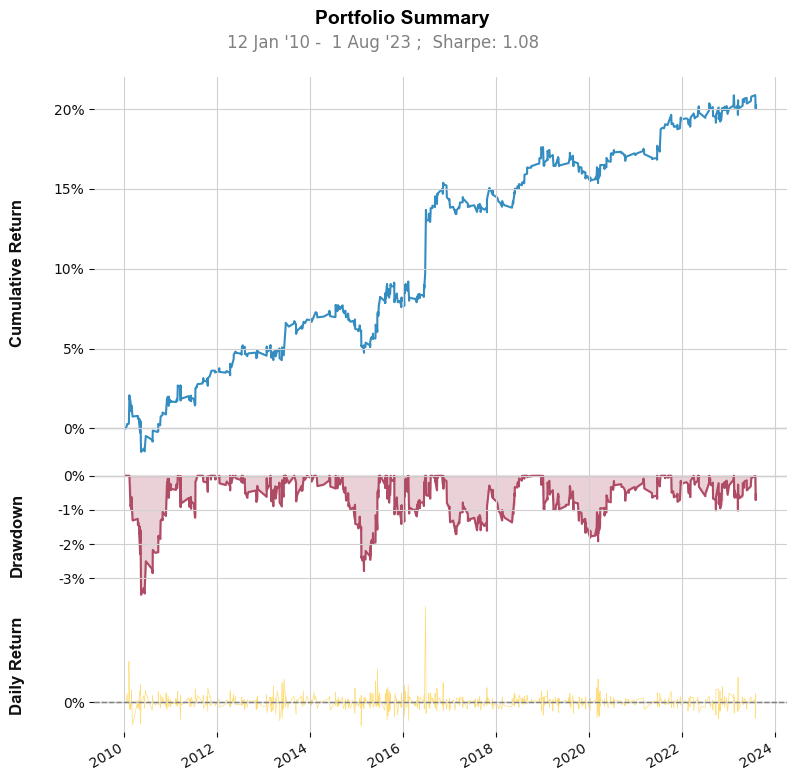

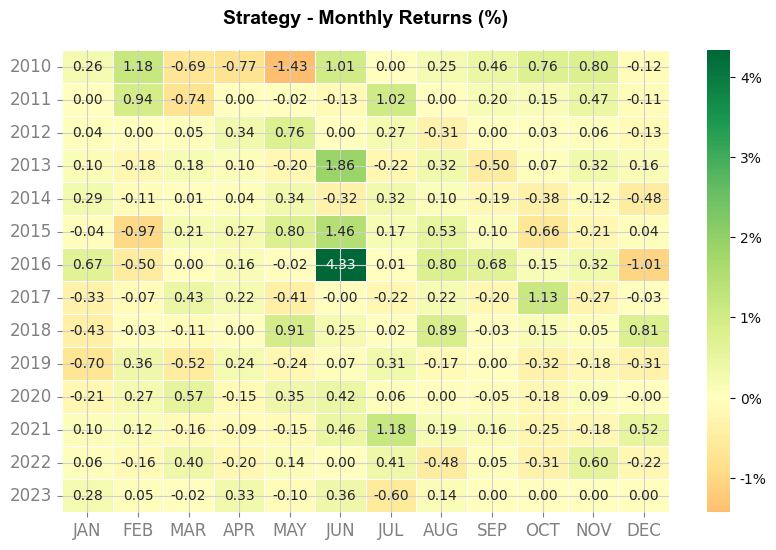

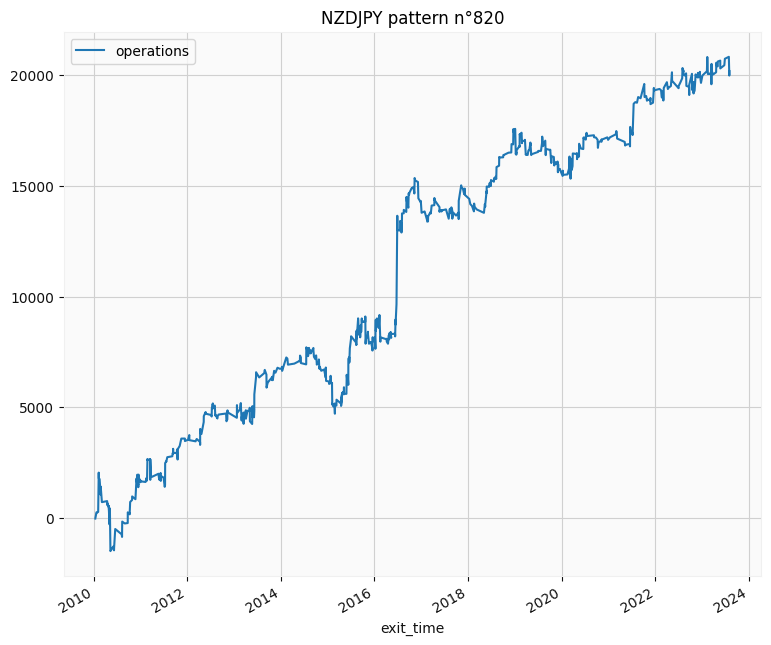

In [114]:

backtest = patternAI.optimize(best_params['threshold_value'], best_params['threshold_pattern'], dataset, price, pattern_detect[IDX], BIGPOINTVALUE, "full", best_params['look_ahead'])
stats = patternAI.stats(backtest, IDX, patternAI.check_direction(IDX, pattern_detect))
display(stats)

patternAI.plot_pattern(pattern_detect,IDX,dataset)

report(backtest.operations,100000,1,"")

backtest.operations.cumsum().plot(figsize=(9,8),title=simbolo+" pattern n°"+str(IDX))
plt.legend()
plt.show()

In [115]:
import pandas as pd

a=backtest.operations.to_frame()

data_M5 = readdata_MT5_Date(simbolo,"M5",path,"2010-01-01","2023-08-28")


In [116]:

direction = patternAI.check_direction(IDX, pattern_detect)

v1 = np.arange(200, 3000, 50, dtype=int)
v1 = np.append(v1 ,10000)
v2 = np.arange(200, 3000, 50, dtype=int) * (-1)
v2 = np.append(v2 ,-10000)


Ricalcolo Open Balance...
Ottimizzazione...


  0%|          | 0/57 [00:00<?, ?it/s]

Ricostruisco Dataframe...
Calcolo delle Performace...


  0%|          | 0/3249 [00:00<?, ?it/s]

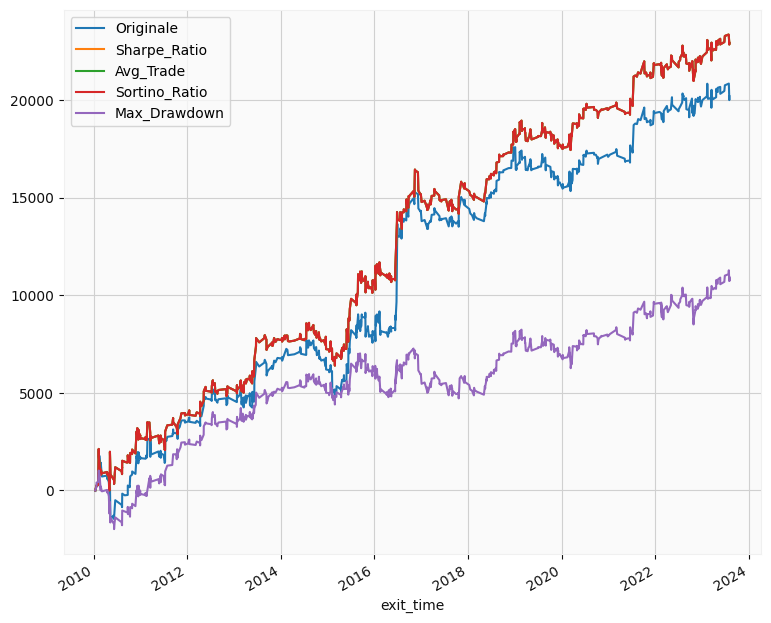

 Sharpe_Ratio 1350_-200 
 Avg_Trade 1350_-200 
 Sortino_Ratio 1350_-200 
 Max_Drawdown 200_-250


In [117]:
patternAI.ottimizza_TP_SL(v1, v2, data_M5, backtest , direction , BIGPOINTVALUE )

In [77]:
idx = IDX

In [78]:
import yfinance as yf

big_diz = {}

for simbolo_ in tqdm(ls_mercati):

    BIGPOINTVALUE_ =get_poin_values(path,simbolo_)
    
    data =  readdata_MT5_Date(simbolo_,"M15",path,"2010-01-01","2023-08-28")
    
    data["bpv"] = BIGPOINTVALUE_

    data = data[data.index.isin(dataset.index)]

    big_diz.update({simbolo_ : data})
    


  0%|          | 0/28 [00:00<?, ?it/s]

In [79]:
pattern_multimarket = pd.DataFrame()

for e in tqdm(big_diz.keys()):
    
    backtest =  patternAI.optimize(best_params['threshold_value'], best_params['threshold_pattern'], dataset,  big_diz[e], pattern_detect[IDX], big_diz[e].bpv[0], "full", best_params['look_ahead']) 
    
    tradelist = backtest.operations.to_frame(e)

    if empyrical.sharpe_ratio(tradelist.iloc[:,0])<0:
        tradelist = -tradelist

    pattern_multimarket = pd.concat([pattern_multimarket,tradelist],axis=1).fillna(0)

  0%|          | 0/28 [00:00<?, ?it/s]

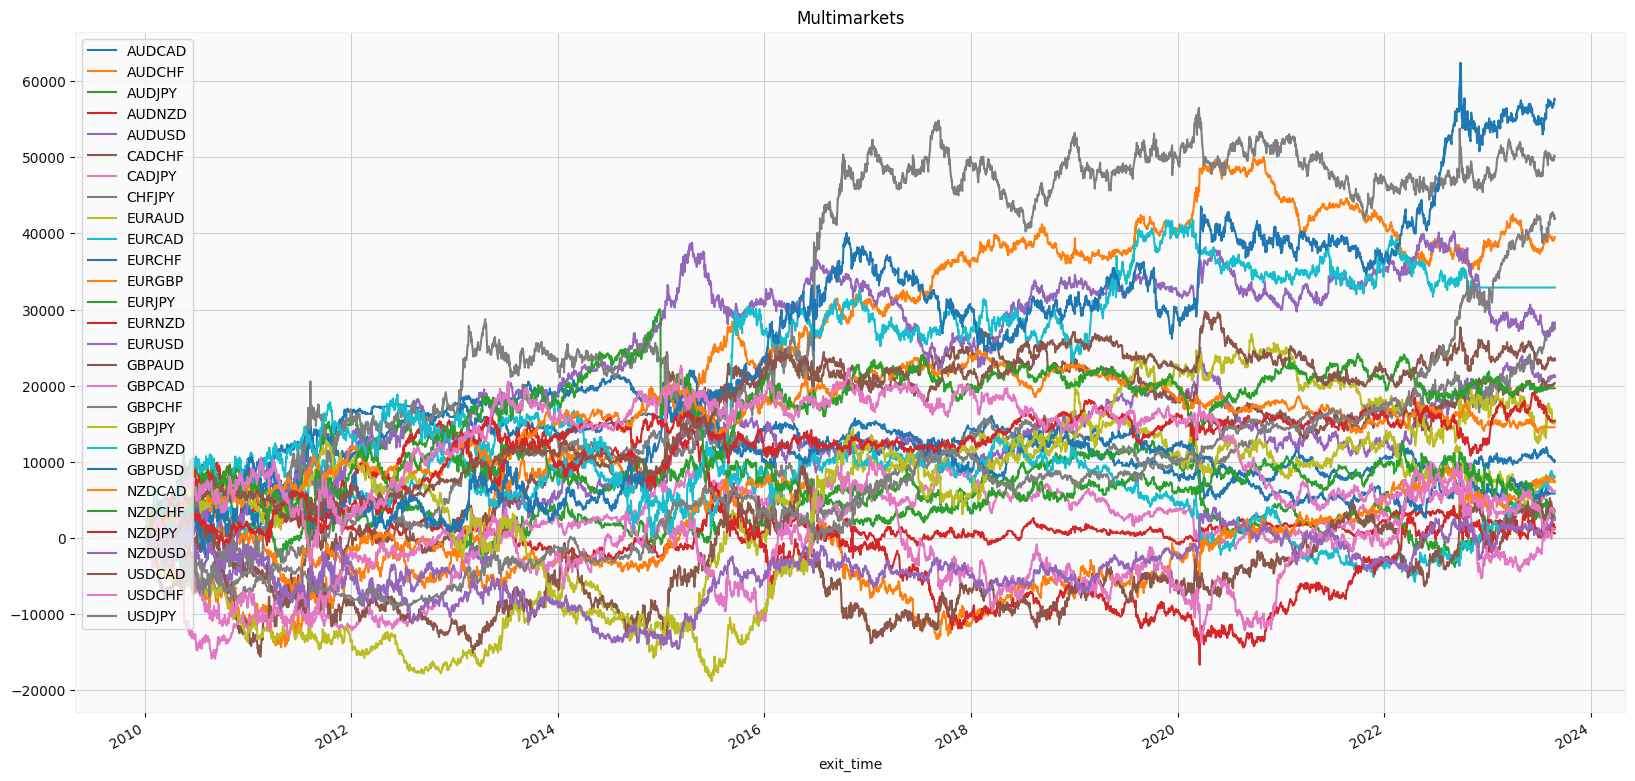

In [80]:
pattern_multimarket.cumsum().plot(figsize=(20,10),title="Multimarkets")
plt.legend(loc='upper left')
plt.show()

In [82]:
pattern_multimarket.tail()

,AUDCAD,AUDCHF,AUDJPY,AUDNZD,AUDUSD,CADCHF,CADJPY,CHFJPY,EURAUD,EURCAD,...,GBPJPY,GBPNZD,GBPUSD,NZDCAD,NZDCHF,NZDJPY,NZDUSD,USDCAD,USDCHF,USDJPY
exit_time,,,,,,,,,,,,,,,,,,,,,
2023-08-11,-283.247542,-290.097921,204.335971,185.550209,-387.891131,-20.945918,-181.561684,747.755784,601.828841,195.413569,...,408.041905,0.0,-745.232364,0.0,-115.202547,-273.293183,-539.714868,190.647384,194.797034,903.385799
2023-08-15,-314.568184,-235.639106,48.079052,-41.845151,-366.598778,59.695865,280.882883,440.935517,-323.969555,-847.699975,...,476.365201,0.0,-287.909646,0.0,0.000000,141.707576,-364.747269,78.301604,153.952495,599.726707
2023-08-17,-298.907863,-215.740692,-204.335971,-210.326943,-493.427143,56.553978,-354.266700,-18.978573,307.202185,-93.281041,...,738.903791,0.0,162.932790,0.0,0.000000,-376.410750,-287.909646,329.547621,35.608060,440.305683
2023-08-21,153.198791,193.747709,-315.044315,1.101188,93.501203,4.189184,0.000000,-1043.821525,-326.963729,34.044176,...,-618.072777,0.0,138.863173,0.0,0.000000,385.900096,-16.663581,99.408993,-204.222697,-619.970646
2023-08-23,204.265054,216.787977,292.902646,-122.782482,220.329569,-103.682292,0.000000,101.219057,-775.490895,-294.141678,...,253.049243,0.0,103.684503,0.0,0.000000,-136.646591,272.171820,113.707547,41.891835,132.850853


In [23]:
import empyrical
sharpe_ok = [e for e in pattern_multimarket.columns if patternAI.Performance_Ratio(pattern_multimarket[e]) > 0.55]
sharpe_ok

['AUDJPY', 'CHFJPY', 'NZDJPY']

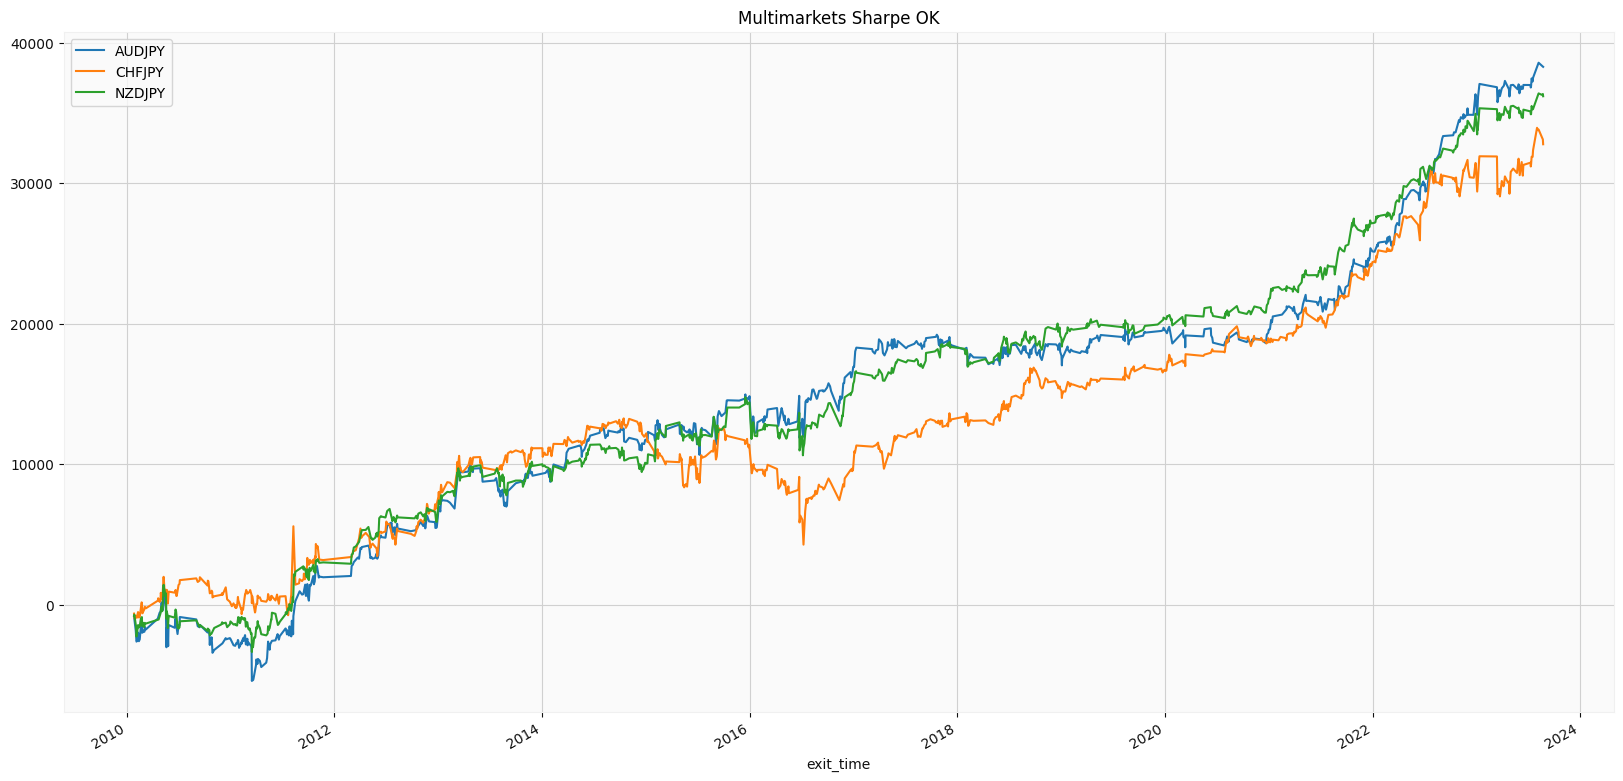

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


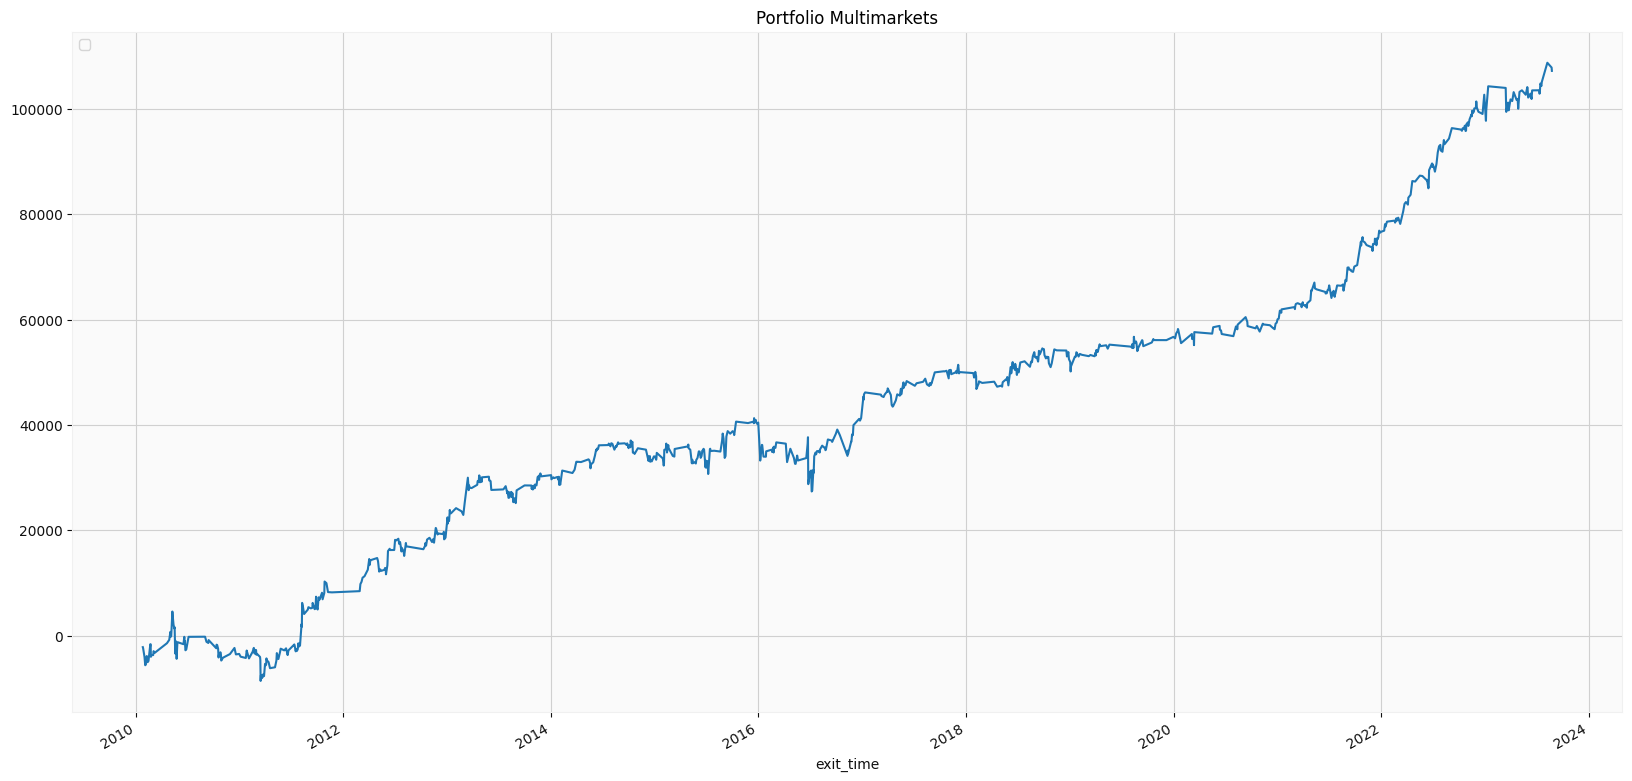

In [24]:
pattern_multimarket[sharpe_ok].cumsum().plot(figsize=(20,10),title="Multimarkets Sharpe OK")
plt.legend(loc='upper left')
plt.show()
pattern_multimarket[sharpe_ok].sum(axis=1).cumsum().plot(figsize=(20,10),title="Portfolio Multimarkets")
plt.legend(loc='upper left')
plt.show()

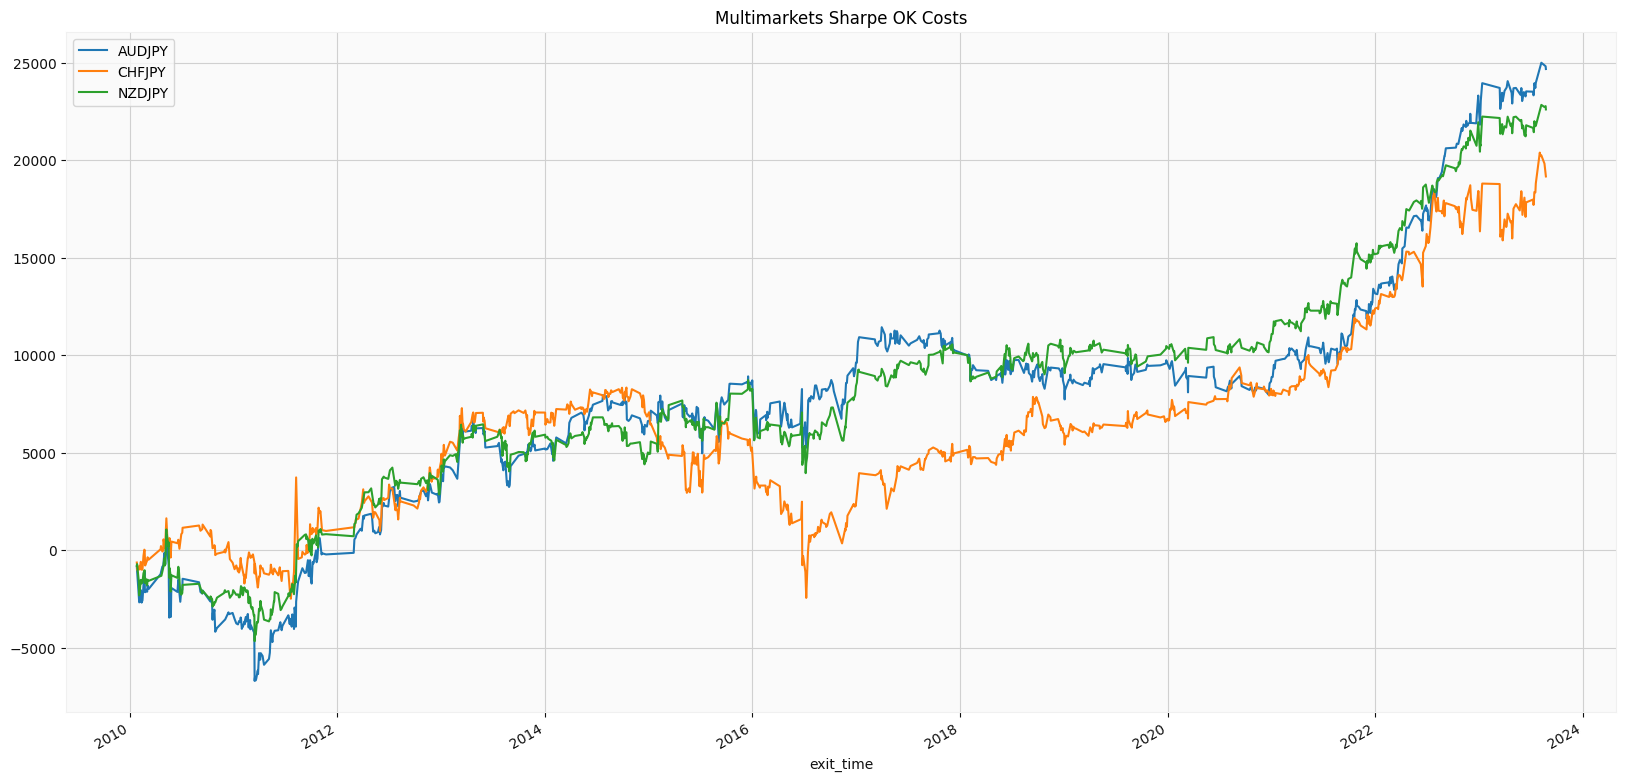

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


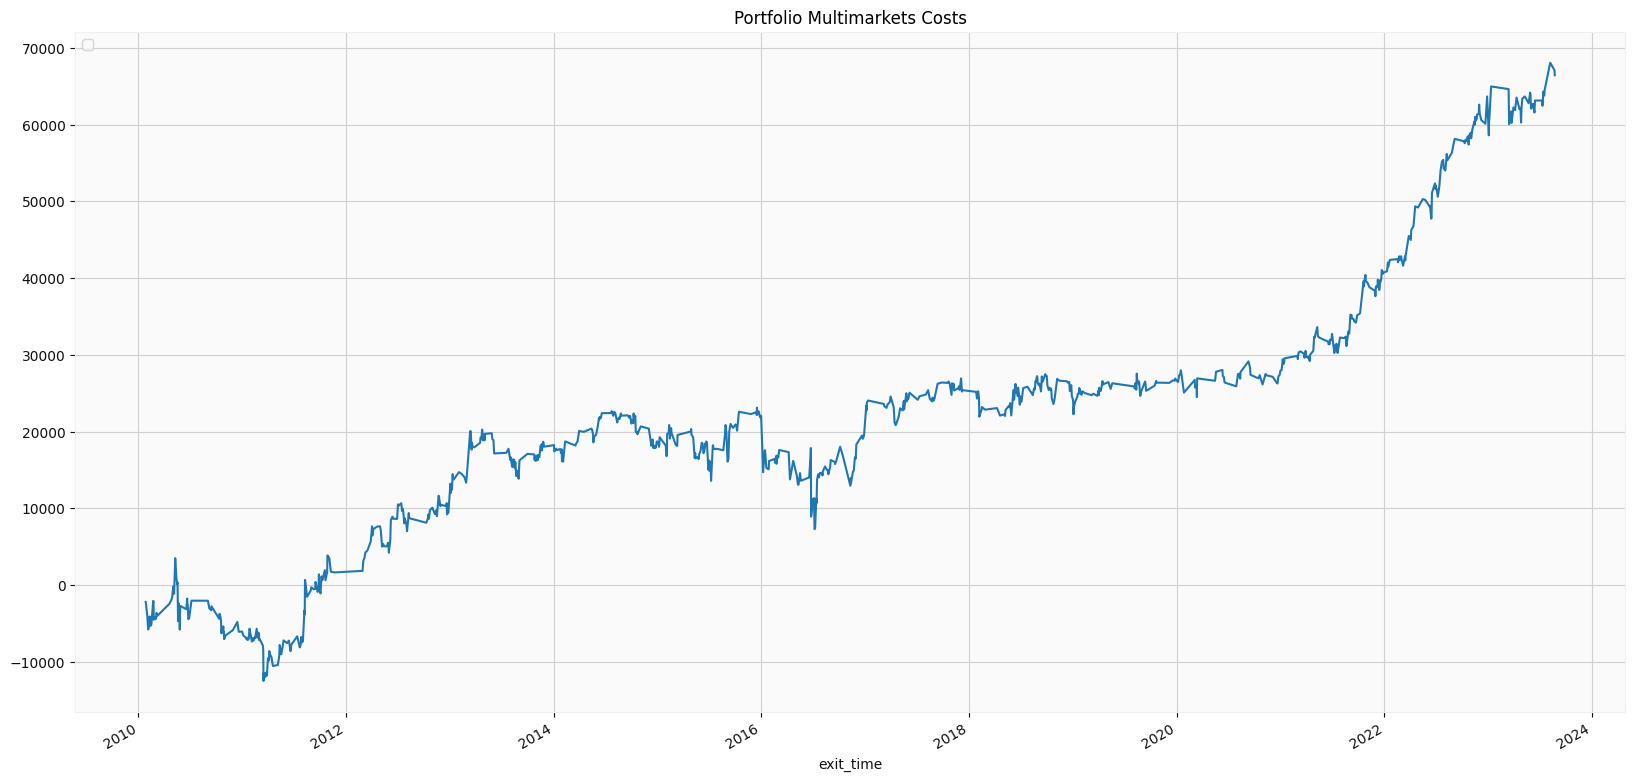

In [25]:
costs = 10

pattern_multimarket_costs = pattern_multimarket.applymap(lambda x: x - costs if x != 0 else x)

pattern_multimarket_costs[sharpe_ok].cumsum().plot(figsize=(20,10),title="Multimarkets Sharpe OK Costs")
plt.legend(loc='upper left')
plt.show()
pattern_multimarket_costs[sharpe_ok].sum(axis=1).cumsum().plot(figsize=(20,10),title="Portfolio Multimarkets Costs")
plt.legend(loc='upper left')
plt.show()

In [108]:
%run ./engine_gandalf_wintermute.py
%run ./functions_gandalf_wintermute.py

5.16.1


<Figure size 640x480 with 0 Axes>

In [109]:
from numba import jit
@jit(nopython=True)
def engine_MP(pct , pct_total , ptn_body , ptn_range , np_data, direzione ,lookback , n_days):
    
    conta=0
    mp=np.zeros_like(np_data[0])

    for i in (range(len(np_data[0])-n_days)):
        if i >lookback:
            op=np_data[0,i-lookback:i] 
            hi=np_data[1,i-lookback:i]
            lo=np_data[2,i-lookback:i]
            cl=np_data[3,i-lookback:i]
    
            a=cl-op
            body=(a - np.min(a))/np.ptp(a)  
            
            a=hi-lo
            range_=(a - np.min(a))/np.ptp(a)
     
            diff_1=body-ptn_body
            diff_2=range_-ptn_range
            diff_1=np.where((diff_1<pct)&(diff_1>-pct),1,diff_1)
            diff_1=np.where(diff_1!=1,0,diff_1)
            diff_2=np.where((diff_2<pct)&(diff_2>-pct),1,diff_2)
            diff_2=np.where(diff_2!=1,0,diff_2)
            
            if (my_sum(diff_1)>=pct_total)&(my_sum(diff_2)>=pct_total)&(direzione=="buy"):
                mp[i] = 1
            if (my_sum(diff_1)>=pct_total)&(my_sum(diff_2)>=pct_total)&(direzione=="sell"):
                mp[i] = 1
    return mp

def to_live(THRESHOLD_VALUE , THRESHOLD_PATTERN, data,  pattern_detect, n_days):
    
        np_data = data.T.values
        ptn_body =  pattern_detect[0]
        ptn_range = pattern_detect[1]
        direzione = pattern_detect[2][0]
        lookback = pattern_detect[2][2]
        #n_days = pattern_detect[2][1]
        
        pct=round(1-float((1/100)*THRESHOLD_VALUE),2)
        pct_total=int((lookback/100)*THRESHOLD_PATTERN)


        signal = engine_MP(pct,pct_total,ptn_body,ptn_range,np_data,direzione,lookback,n_days)

        return signal

In [111]:

dataset["signal"] = to_live(70, 70, dataset,  pattern_detect[IDX],  2)


9

In [112]:
pattern_detect[IDX]

array([array([0.88685345, 0.72198276, 0.67672414, 0.67241379, 0.79094828,
              0.56357759, 0.68642241, 0.64978448, 0.60883621, 0.70150862,
              0.56142241, 1.        , 0.61422414, 0.6325431 , 0.61422414,
              0.86530172, 0.51616379, 0.41594828, 0.30711207, 0.33297414,
              0.71012931, 0.46767241, 0.85560345, 0.83189655, 0.78448276,
              0.52478448, 0.59698276, 0.        , 0.92241379, 0.42349138]),
       array([0.39101717, 0.15323646, 0.38044914, 0.24174373, 0.2668428 ,
              0.08718626, 0.19418758, 0.05944518, 0.        , 0.17569353,
              0.26287979, 0.47688243, 0.03038309, 0.08982827, 0.2668428 ,
              0.29590489, 0.08058124, 0.17569353, 0.37780713, 0.47556143,
              0.10303831, 0.20871863, 0.45706737, 0.74636724, 0.31836196,
              0.02113606, 0.15587847, 1.        , 0.41875826, 0.10700132]),
       list(['buy', 2, 30, 0.005, 957])], dtype=object)

In [122]:
NAME = "Tester"

WRITELOG = False

EXIT_ON_ENTRY_BAR = False
CONSECUTIVE_TRADES = True

COSTS_FIXED = 0
# 10 for 10 $ for each transaction (2 * fee each operation)
COSTS_VARIABLE = 0.0
# 1.0 for 1% (2 * fee each operation)
COSTS_PERSHARES = 0.0 
# 0.01 for 1 cent for each shares traded (2 * fee each operation)

INSTRUMENT = 2 # 1: equity, 2: future, 3: crypto/forex
TICK = 0.1
BIGPOINTVALUE = BIGPOINTVALUE
DIRECTION = "long"
ORDER_TYPE = "market"
MAX_INTRADAY_OPERATIONS = 1000

QUANTITY = 1
MARGIN_PERCENT = 10 # margin to use in capital calculation

TIME_EXIT = 2  # 0 to disable
TIME_EXIT_LOSS = 0  # 0 to disable
TIME_EXIT_GAIN = 0  # 0 to disable

MONEY_STOPLOSS = 0  # 0 to disable
MONEY_TARGET = 0  # 0 to disable

MIN_MONEY_PERCENT_STOPLOSS = 0
PERCENT_STOPLOSS = 0.0  # 0 to disable

MIN_MONEY_PERCENT_TARGET = 0
PERCENT_TARGET = 0.0  # 0 to disable

# enter_level in case of ORDER_TYPE = "stop" or ORDER_TYPE = "limit"
#enter_level = dataset.session_open + 0.5 * dataset.session_range1
enter_level = dataset.high.rolling(23).max().shift(1)

enter_rules = dataset["signal"] == 1

exit_rules = False

exit_rules_loss = False

exit_rules_gain = False 

target_level = 0 # 0 to disable

stop_level = 0 # 0 to disable


tradelist, open_equity, closed_equity, operation_equity = apply_trading_system(dataset, INSTRUMENT, QUANTITY, MARGIN_PERCENT, BIGPOINTVALUE, TICK, DIRECTION,
                                                                               COSTS_FIXED, COSTS_VARIABLE, COSTS_PERSHARES, 
                                                                               ORDER_TYPE, enter_level, enter_rules, MAX_INTRADAY_OPERATIONS, 
                                                                               exit_rules, exit_rules_loss, exit_rules_gain,
                                                                               target_level, stop_level,
                                                                               TIME_EXIT, TIME_EXIT_LOSS, TIME_EXIT_GAIN, 
                                                                               MONEY_STOPLOSS, MONEY_TARGET, 
                                                                               PERCENT_STOPLOSS, MIN_MONEY_PERCENT_STOPLOSS, 
                                                                               PERCENT_TARGET, MIN_MONEY_PERCENT_TARGET, WRITELOG, EXIT_ON_ENTRY_BAR, CONSECUTIVE_TRADES)

# True: Interactive, False: Static
#performance_report(dataset, tradelist, closed_equity, open_equity, 100000, 0, MARGIN_PERCENT, False)



Elaboration starting at: 2023-09-05 18:35:16.391742
Elaboration completed at: 2023-09-05 18:35:16.399749 in 0:00:00.008007

Consistency check: entries: 1741 exits: 1741

Last trade still open: we close it on last bar and we compute open position as closed position!



<Axes: >

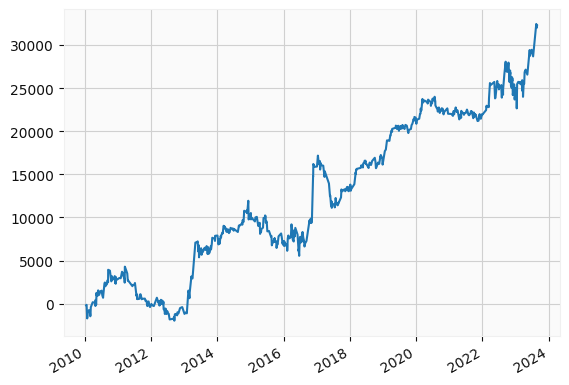

In [123]:
tradelist.operations.cumsum().plot()

<Axes: xlabel='exit_time'>

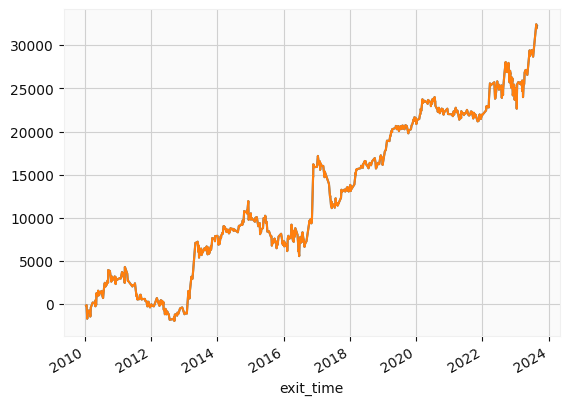

In [124]:
tradelist.operations.cumsum().plot()
backtest.operations.cumsum().plot()